In [104]:
from mmcv import Config
from mmseg.apis.inference import init_segmentor
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from mmseg.models.uda.dacs import Refinement
from mmseg.models.uda.refinement import Guidance, OverlapPatchEmbed,EncodeDecode,Encoder
from mmseg.models.uda.MGDN import DeepMuGIF
from mmseg.models.uda.swinir_backbone import MGDNRefinement,Block
from mmseg.datasets import build_dataset

import json
from torch.nn import CrossEntropyLoss
from mmseg.models.backbones.mix_transformer import MixVisionTransformer
from mmseg.models.decode_heads.segformer_head import SegFormerHead
import torch.nn.functional as F

In [105]:
cfg = Config.fromfile('configs/_base_/datasets/uda_GTA_to_Cityscapes_colour.py')

In [109]:
train_dataset = build_dataset(cfg.data.train)

In the build dataset
In the UDADataset
In the build dataset


2025-05-05 12:00:26,255 - mmseg - INFO - Loaded 24964 images from data/gta/images
2025-05-05 12:00:26,310 - mmseg - INFO - Loaded 2975 images from data/cityscapes/leftImg8bit/train/


In the build dataset


In [124]:
sample = train_dataset[3]
sample["sam_pseudo_label"]

DataContainer(tensor([[[18, 18, 18,  ...,  8,  8,  8],
         [18, 18, 18,  ...,  8,  8,  8],
         [18, 18, 18,  ...,  8,  8,  8],
         ...,
         [11, 11, 11,  ..., 11, 11, 11],
         [11, 11, 11,  ..., 11, 11, 11],
         [11, 11, 11,  ..., 11, 11, 11]]]))

In [125]:
sample.keys()

dict_keys(['img_metas', 'img', 'gt_semantic_seg', 'sam_pseudo_label', 'target_img_metas', 'target_img'])

In [101]:
cityscaps_path = "data/gta/sam_colour/00001.png"

(-0.5, 1913.5, 1051.5, -0.5)

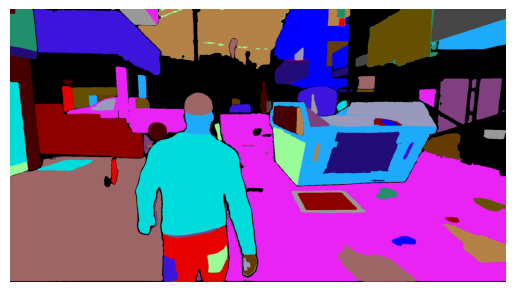

In [102]:
cityscaps_sam = "data/cityscapes/sam_colour/aachen_000000_000019_leftImg8bit_pseudoTrainIds.png"
sam = torch.tensor(cv2.imread(cityscaps_path))
plt.imshow(sam)
plt.axis("off")

In [103]:
sam.unique()

tensor([  0,  11,  20,  30,  32,  35,  60,  64,  70,  80, 100, 102, 107, 119,
        128, 130, 142, 152, 153, 156, 170, 180, 190, 220, 230, 232, 244, 250,
        251, 255], dtype=torch.uint8)

(-0.5, 1913.5, 1051.5, -0.5)

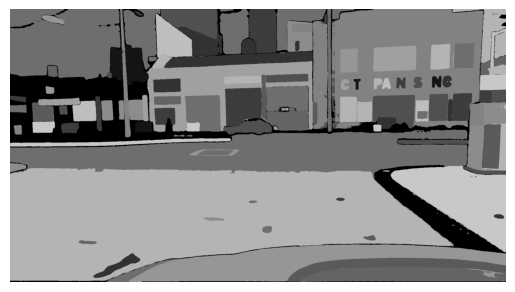

In [90]:
gta_sam = "data/gta/sam_colour/00003_pseudoTrainIds.png"
sam = torch.tensor(cv2.imread(gta_sam))*10
plt.imshow(sam)
plt.axis("off")

In [91]:
sam.shape

torch.Size([1052, 1914, 3])

In [3]:
image = cv2.imread(cityscaps_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
cityscaps_img = torch.tensor(image,dtype=torch.float32).transpose(2,0).transpose(1,2)

In [4]:
cityscaps_img = cityscaps_img.unsqueeze(0)[:,:,:,:-1024]


In [5]:
cityscaps_img.shape,cityscaps_img.dtype

(torch.Size([1, 3, 1024, 1024]), torch.float32)

In [6]:
model = MGDNRefinement()
conv = nn.Conv2d(3,1,kernel_size=1)
block = Block(60)
cityscaps_img = conv(cityscaps_img)

In [10]:
conv = nn.Conv2d(1,60,kernel_size=1,stride=4)
t = conv(cityscaps_img)
embed = block((t,t))

In [37]:
t = block((t,t))

In [33]:
t.shape

torch.Size([1, 60, 256, 256])

In [7]:
cityscaps_img.shape

torch.Size([1, 1, 1024, 1024])

In [12]:
t = model(cityscaps_img,cityscaps_img)

In [13]:
t.shape

torch.Size([1, 19, 1024, 1024])

In [18]:
block = Block(60)

In [19]:
res = block((t,t))

In [20]:
res.shape

torch.Size([1, 60, 1024, 1024])